https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

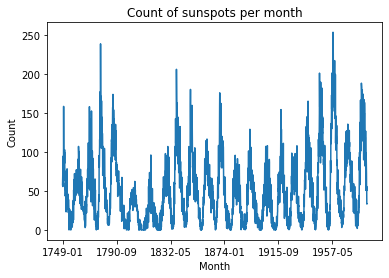

In [74]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
 
def parser(x):
    return datetime.strptime(x, '%Y-%m')

sunspots = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'
df = pd.read_csv(sunspots,date_parser=parser).set_index('Month')
X = df['Sunspots']
plt.title('Count of sunspots per month')
X.plot()
plt.ylabel('Count')
plt.show()

In [66]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

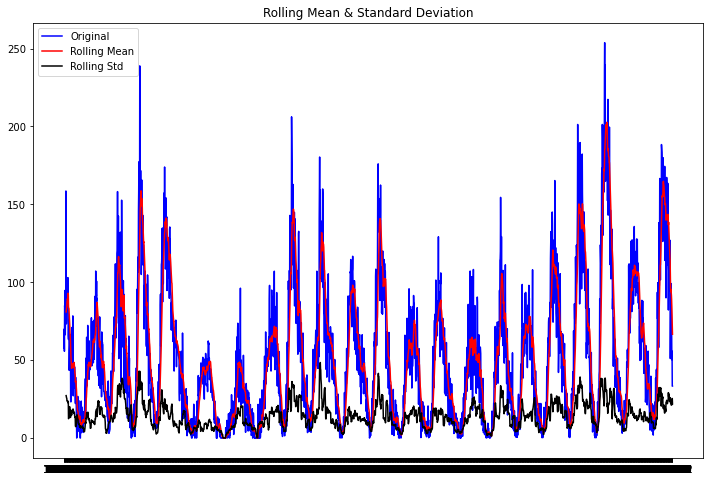

Results of Dickey-Fuller Test:
Test Statistic                -9.567668e+00
p-value                        2.333452e-16
#Lags Used                     2.700000e+01
Number of Observations Used    2.792000e+03
Critical Value (1%)           -3.432694e+00
Critical Value (5%)           -2.862576e+00
Critical Value (10%)          -2.567321e+00
dtype: float64


In [67]:
test_stationarity(df)

# Plot autocorrelation function

* Suggests p<=1

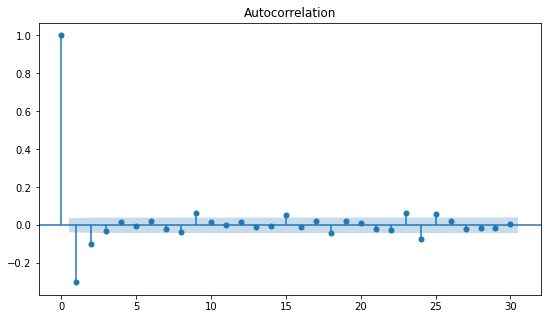

In [73]:
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(9,5))
plot_acf(df.diff().dropna(), lags=30, ax=ax)
plt.show()

# Plot partial auto correlation

* Suggests q<=1

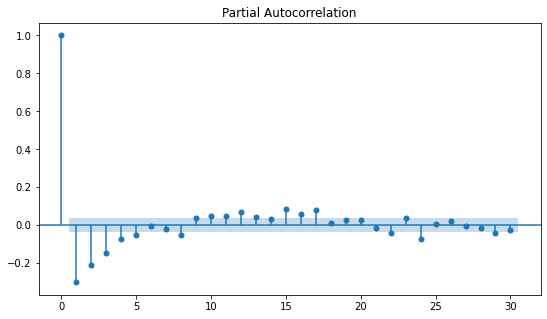

In [72]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(df.diff().dropna(), lags=30, ax=ax)
plt.show()

In [9]:
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    splits = TimeSeriesSplit(n_splits=2,test_size=int(0.2*len(X)))
    rmse_test_values = []
    for train_index, test_index in splits.split(X):
        train = X[train_index]
        history = [x for x in train]
        test = X[test_index]
        predictions = []
        print('Observations: %d' % (len(train) + len(test)))
        print('Training Observations: %d' % (len(train)))
        print('Testing Observations: %d' % (len(test)))
        # make predictions
        predictions = list()
        for t in range(len(test)):
            model = ARIMA(history, order=arima_order)
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)
            history.append(test[t])
            # calculate out of sample error
        rmse_test = sqrt(mean_squared_error(test, predictions))
        rmse_test_values.append(rmse_test)
    return np.mean(rmse_test_values)

In [10]:
import warnings
warnings.filterwarnings('ignore')
evaluate_models(X,[0,1],[0,1],[0,1])

Observations: 2256
Training Observations: 1692
Testing Observations: 564
Observations: 2820
Training Observations: 2256
Testing Observations: 564
ARIMA(0, 0, 0) RMSE=46.844
Observations: 2256
Training Observations: 1692
Testing Observations: 564
Observations: 2820
Training Observations: 2256
Testing Observations: 564
ARIMA(0, 0, 1) RMSE=31.106
Observations: 2256
Training Observations: 1692
Testing Observations: 564
Observations: 2820
Training Observations: 2256
Testing Observations: 564
ARIMA(0, 1, 0) RMSE=17.710
Observations: 2256
Training Observations: 1692
Testing Observations: 564
Observations: 2820
Training Observations: 2256
Testing Observations: 564
ARIMA(0, 1, 1) RMSE=16.617
Observations: 2256
Training Observations: 1692
Testing Observations: 564
Observations: 2820
Training Observations: 2256
Testing Observations: 564
ARIMA(1, 0, 0) RMSE=17.429
Observations: 2256
Training Observations: 1692
Testing Observations: 564
Observations: 2820
Training Observations: 2256
Testing Observa

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2256
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -9299.552
Date:                Wed, 06 Apr 2022   AIC                          18605.104
Time:                        14:26:47   BIC                          18622.266
Sample:                             0   HQIC                         18611.367
                               - 2256                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2187      0.030      7.409      0.000       0.161       0.277
ma.L1         -0.6563      0.023    -28.815      0.000      -0.701      -0.612
sigma2       223.6146      3.892     57.458      0.0

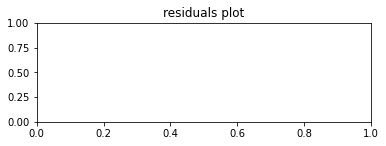

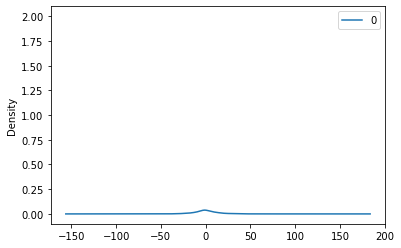

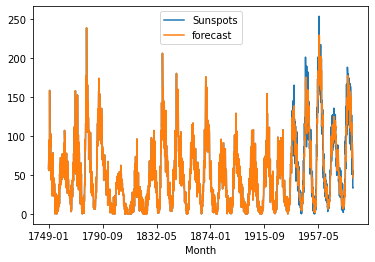

In [64]:
#def model_report(data,parameters):
data_list = list(df['Sunspots'])
parameters=(1,1,1)
train_size = int(0.8*len(data_list))
train = data_list[:train_size]
test = data_list[train_size:]
history = [j for j in train]
predictions = []
summary = None
for t in test:
    model = ARIMA(history, order=parameters)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    if summary is None:
        summary = model_fit.summary()
        residuals = pd.DataFrame(model_fit.resid)
    predictions.append(yhat)
    history.append(t)
print(summary)
plt.subplot(2,1,1)
plt.title('residuals plot')
residuals.plot(kind='kde')
rmse = sqrt(mean_squared_error(test, predictions))
plotframe = df.copy()
plotframe['forecast'] = train+predictions
plt.plot(2,1,2)
plotframe.plot()
#plt.plot(3,1,3)
plt.show()